<a href="https://colab.research.google.com/github/gregorywmorris/MLZoom2022/blob/main/midterm/Stroke_Prediction_MLZoomcamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Auto-save / Auto-reload
%autosave 1

%load_ext autoreload
%autoreload 2

Autosaving every 1 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Why Predicting Stroke Likelihood Matters





### By the Numbers
**Global**

Strokes are a global epidemic. They are the second leading cause of death and have increased by 70% between 1990 to 2019, with death from strokes inceasing by 43% ([source](https://www.thelancet.com/journals/laneur/article/PIIS1474-4422(21)00252-0/fulltext)). The WHO estimates the anual cost of strokes to be over US$721 billion ([source](https://pubmed.ncbi.nlm.nih.gov/34986727/#:~:text=Abstract,%25%20of%20the%20global%20GDP))).

**United States**

While strokes have been declining for decades in the US, it still has a large financial burden, amounting to $53 billion anually ([source](https://www.cdc.gov/stroke/facts.htm)). Currently stroke is the 5th leading cause of death in the US ([source](https://www.cdc.gov/nchs/fastats/leading-causes-of-death.htm)).

### Optimal Outcomes
**Global**

Predicting stroke can provide an opportunity to take corrective actions before a stroke occurs. Most importantly, resulting in fewer deaths and disabilities.

Addtionally, the money lost to strokes would boost econamies. Assuming cost and stroke occurance are linear, if strokes were reduced by just 5%, that would inject $36 billion into world economies.

**United States**

And $2.65 billion into the US econamy.

# Stroke Data

### An Appropriate Dataset
A seach for various stroke datasets that included health factors showed that the [Kaggle dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) was best suited. Numerous other stroke datasets are avaialbe but the lacked health factors needed. Datasets were often location based or even post stroke images. Neither are well suited for the the desired task.

### Limitations

* It is known that there are more factors for stroke prediction (such as [lab tests](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8686476/), lifestyle, etc.) than are avaialble in this data set.
  * However, [the most important factors](https://www.sciencedirect.com/science/article/pii/S2772442522000090) are in the dataset
* This data set was uploaded 2 years ago with no expectations of being updated.
* The source and accuracy to the data is unkown, a verified healthcare organization would be an ideal source for stroke data.

# Extract-Load-Transform (ELT)

#### The Process


**Extract:** Data is extracted from [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) to [GitHub](https://github.com/gregorywmorris/MLZoom2022/blob/main/midterm/healthcare-dataset-stroke-data.csvhttps://github.com/gregorywmorris/MLZoom2022/blob/main/midterm/healthcare-dataset-stroke-data.csv)

**Load:** Data is loaded to the notebook

**Transform:** Data is modified to suit and improve the model

### Load

In [ ]:
data = 'https://raw.githubusercontent.com/gregorywmorris/MLZoom2022/main/midterm/healthcare-dataset-stroke-data.csv'

In [ ]:
!wget $data -O data.csv

--2022-10-25 13:53:19--  https://raw.githubusercontent.com/gregorywmorris/MLZoom2022/main/midterm/healthcare-dataset-stroke-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 316971 (310K) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>] 309.54K  --.-KB/s    in 0.03s   

2022-10-25 13:53:20 (9.10 MB/s) - ‘data.csv’ saved [316971/316971]



In [ ]:
import pandas as pd
import numpy as np


In [ ]:
df = pd.read_csv('data.csv')

### Transform - Exploritory Data Analysis (EDA)

##### **Module Imports**

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import ttest_ind
import pylab
import seaborn as sns
import matplotlib.pyplot as plt

##### **Overview**

In [ ]:
df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


'id' column is not needed.

In [ ]:
df = df.drop(columns='id')

In [ ]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

Categories need to be converted to numberical values.

In [ ]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Column names are need to be normalized to all lower case (see Residence_type), bmi N/A needs to be adressed.

In [ ]:
col = df.columns.tolist()
df = df.rename(str.lower, axis='columns')
col = df.columns.tolist() # list with new column names all lower case

In [ ]:
# Check for zeros in columns that it would not make sense to exist in. 

(df[col] == 0).all()

gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
residence_type       False
avg_glucose_level    False
bmi                  False
smoking_status       False
stroke               False
dtype: bool

In [ ]:
df.describe() # statistiacal overview, look for outliers or oddities

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Min age of 0.08, expected whole integers.

In [ ]:
df.skew()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


age                 -0.137059
hypertension         2.715392
heart_disease        3.947244
avg_glucose_level    1.572284
bmi                  1.055340
stroke               4.193284
dtype: float64

Distribution of all features are all highly possitivley skewed except for age which is slightly negatively skewed. 

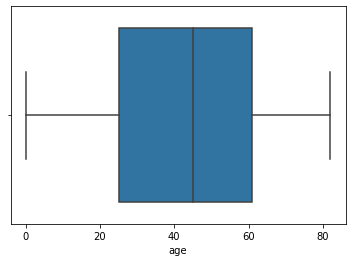

In [ ]:
sns.boxplot(x=df.age)

Age is distributed as expected. 

##### **df.bmi**

###### **Overview**
Average zeros based on groups of either possitive for stroke or not. Suspect possible difference in grouping.

In [ ]:
stroke_mean_0, stroke_mean_1 =df.groupby('stroke')['bmi'].mean()
stroke_mean_0, stroke_mean_1 # 0 not a stroke and 1 is a stroke

(28.823063829787234, 30.471291866028707)

In [ ]:
round((stroke_mean_1-stroke_mean_0)/stroke_mean_1,2)

0.05

Slight variance of 5% in bmi mean, note dtype is float64

Review the distribution of bmi as a total and by stroke value

((array([-3.6412931, -3.4063133, -3.2768215, ...,  3.2768215,  3.4063133,
          3.6412931]), array([10.3, 11.3, 11.5, ...,  nan,  nan,  nan])),
 (nan, nan, nan))

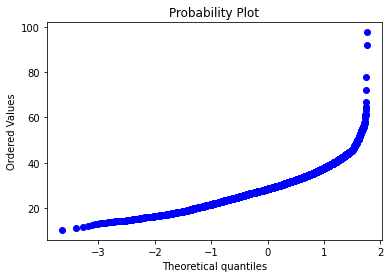

In [ ]:
stats.probplot(df.bmi,fit=True, plot=pylab )

The probability plot shows that the bmi distribution is not normal (should show along a 45 degree line). Next step is to see if the distribution can be transformed to a normal distribuion for a p-value analysis.

###### **Normalize df.bmi Distribution**

Unable to normalize the distibution

[Normalization techniques](https://www.analyticsvidhya.com/blog/2021/05/how-to-transform-features-into-normal-gaussian-distribution/)

In [ ]:
def normality(data,feature):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.kdeplot(data[feature])
    plt.subplot(1,2,2)
    stats.probplot(data[feature],plot=pylab)
    plt.show()

In [ ]:
df_cp = df.copy() #must reimport data if this is ran after changes are made.

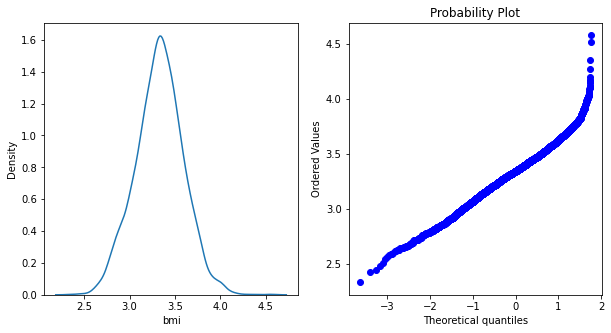

0.0011326087933981655

In [ ]:
#performing logarithmic transformation on the feature
df2 = df_cp.copy()
df2.bmi=np.log(df.bmi)
normality(df2,'bmi')
df2.bmi.skew()

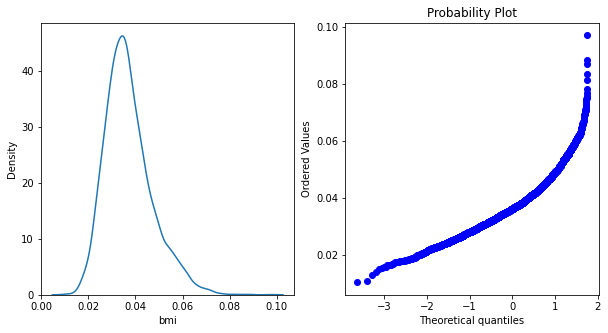

0.8591866889536662

In [ ]:
#Reciprocal Transformation
df2 = df_cp.copy()
df2.bmi=1/df2.bmi
normality(df2,'bmi')
df2.bmi.skew()

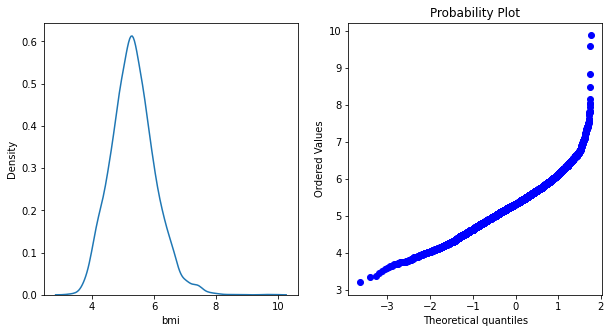

0.4748565689090631

In [ ]:
#Square Root Transformation
df2 = df_cp.copy()
df2.bmi=np.sqrt(df2.bmi)
normality(df2,'bmi')
df2.bmi.skew()

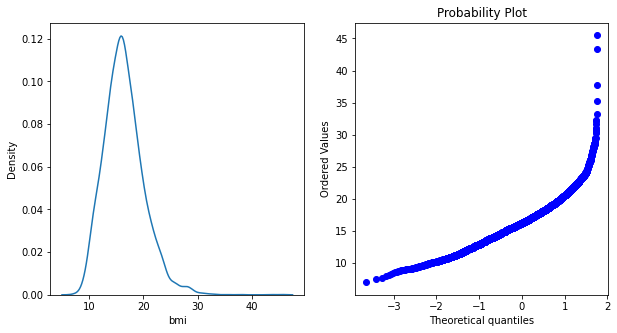

0.8439381127696062

In [ ]:
#Exponential Transformation
df2 = df_cp.copy()
df2.bmi=df.bmi**(1/1.2)
normality(df2, 'bmi')
df2.bmi.skew()

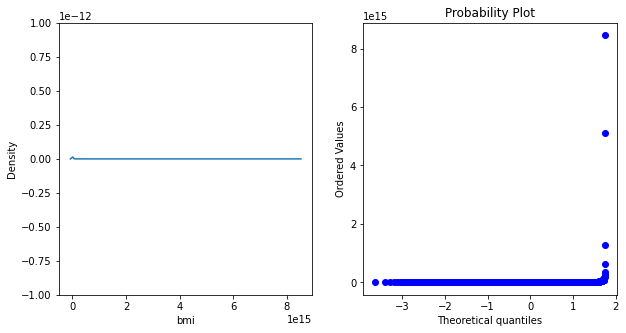

51.59532132895192

In [ ]:
#Box-Cox Transformation
df2 = df_cp.copy()
df2.bmi,parameters=stats.boxcox(df2.bmi)
normality(df2,'bmi')
df2.bmi.skew()

###### **p-value**
The two sample test tells shows that the difference in the bmi distributions are NOT statistiacally signifigant. Replacing the missing values with the overall mean is justified.

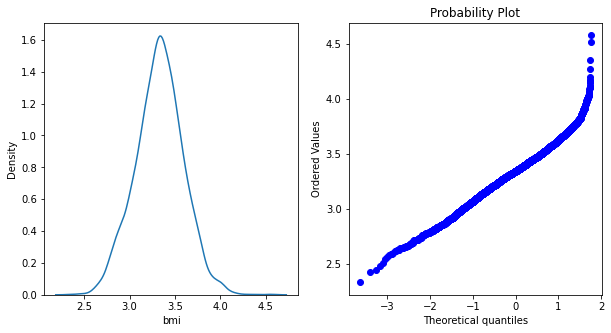

0.0011326087933981655

In [ ]:
df2 = df.copy()
df2.bmi=np.log(df.bmi)
normality(df2,'bmi')
df2.bmi.skew()

The distribution is very close to normal, only off by 0.001

stroke
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: bmi, dtype: object

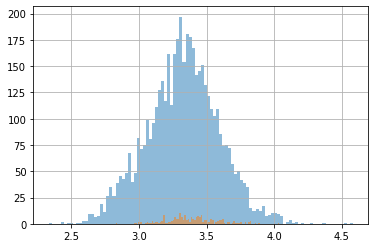

In [ ]:
df2.groupby('stroke')['bmi'].hist(bins=100, alpha=0.5)

In [ ]:
stroke_0, stroke_1 =df2.groupby('stroke')['bmi']

In [ ]:
# one sample
stats.ttest_1samp(a=stroke_1[1],popmean=df2.stroke.mean(), nan_policy='omit')

Ttest_1sampResult(statistic=241.32120461956097, pvalue=1.2046087371152927e-256)

The  one sample test tells shows that the difference in the bmi distributions are **NOT** statistiacally signifigant. Replacing the missing values with the overall mean is justified.

###### **final**

In [ ]:
df.bmi = df.bmi.fillna(df.bmi.mean())

##### **df.age**

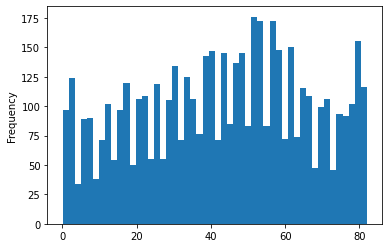

In [ ]:
df.age.plot.hist(bins=50)

In [ ]:
df.age.value_counts()

78.00    102
57.00     95
52.00     90
54.00     87
51.00     86
        ... 
1.40       3
0.48       3
0.16       3
0.40       2
0.08       2
Name: age, Length: 104, dtype: int64

Clarification on age [here](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/discussion/223242?search=age), decimal places represent days. 

##### **df.residence_type**

In [ ]:
rt = df.residence_type.value_counts().copy()
rt

Urban    2596
Rural    2514
Name: residence_type, dtype: int64

In [ ]:
df.residence_type = (df.residence_type == 'Urban').astype(int)
df.residence_type.value_counts()

1    2596
0    2514
Name: residence_type, dtype: int64

##### **df.ever_married**

In [ ]:
em = df.ever_married.value_counts()
em

Yes    3353
No     1757
Name: ever_married, dtype: int64

In [ ]:
# convert Yes and No to 1 and 0.
df.ever_married = (df.ever_married == 'Yes').astype(int)
df.ever_married.value_counts()

1    3353
0    1757
Name: ever_married, dtype: int64

##### **df.gender**

In [ ]:
gender = df.gender.value_counts().copy()
gender

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [ ]:
dummies = pd.get_dummies(df.gender)
df = pd.concat([df, dummies],axis='columns')
del df['gender'] # drop gender
df.columns

Index(['age', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'residence_type', 'avg_glucose_level', 'bmi', 'smoking_status',
       'stroke', 'Female', 'Male', 'Other'],
      dtype='object')

##### **df.work_type**

In [ ]:
wt = df.work_type.value_counts().copy()
wt

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [ ]:
dummies = pd.get_dummies(df.work_type)
df = pd.concat([df, dummies],axis='columns')
del df['work_type']
df.columns

Index(['age', 'hypertension', 'heart_disease', 'ever_married',
       'residence_type', 'avg_glucose_level', 'bmi', 'smoking_status',
       'stroke', 'Female', 'Male', 'Other', 'Govt_job', 'Never_worked',
       'Private', 'Self-employed', 'children'],
      dtype='object')

##### **df.smoking_status**

In [ ]:
ss = df.smoking_status.value_counts().copy()
ss

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [ ]:
dummies = pd.get_dummies(df.smoking_status)
df = pd.concat([df, dummies],axis='columns')
del df['smoking_status']
df.columns

Index(['age', 'hypertension', 'heart_disease', 'ever_married',
       'residence_type', 'avg_glucose_level', 'bmi', 'stroke', 'Female',
       'Male', 'Other', 'Govt_job', 'Never_worked', 'Private', 'Self-employed',
       'children', 'Unknown', 'formerly smoked', 'never smoked', 'smokes'],
      dtype='object')

##### **Coninued EDA**

In [ ]:
# convert new column names to lower
col = df.columns.tolist()
df = df.rename(str.lower, axis='columns')
col = df.columns.tolist() # list with new column names all lower case


In [ ]:
# confirm column names and dtypes
df.dtypes

age                  float64
hypertension           int64
heart_disease          int64
ever_married           int64
residence_type         int64
avg_glucose_level    float64
bmi                  float64
stroke                 int64
female                 uint8
male                   uint8
other                  uint8
govt_job               uint8
never_worked           uint8
private                uint8
self-employed          uint8
children               uint8
unknown                uint8
formerly smoked        uint8
never smoked           uint8
smokes                 uint8
dtype: object

Dummy columns may lose context once separated. Renaming columns would make the data more readable. Addionally the name word spacing should use '_' rather than ' ' or '-'.

In [ ]:
df = df.rename(columns={'other': 'other_gender','formerly smoked':'formerly_smoked','never smoked':'never_smoked','unknown':'unknown_smoking','children': 'is_a_child','private': 'employed','self-employed':'self_employed' })

In [ ]:
# Confirm changes
df.dtypes

age                  float64
hypertension           int64
heart_disease          int64
ever_married           int64
residence_type         int64
avg_glucose_level    float64
bmi                  float64
stroke                 int64
female                 uint8
male                   uint8
other_gender           uint8
govt_job               uint8
never_worked           uint8
employed               uint8
self_employed          uint8
is_a_child             uint8
unknown_smoking        uint8
formerly_smoked        uint8
never_smoked           uint8
smokes                 uint8
dtype: object

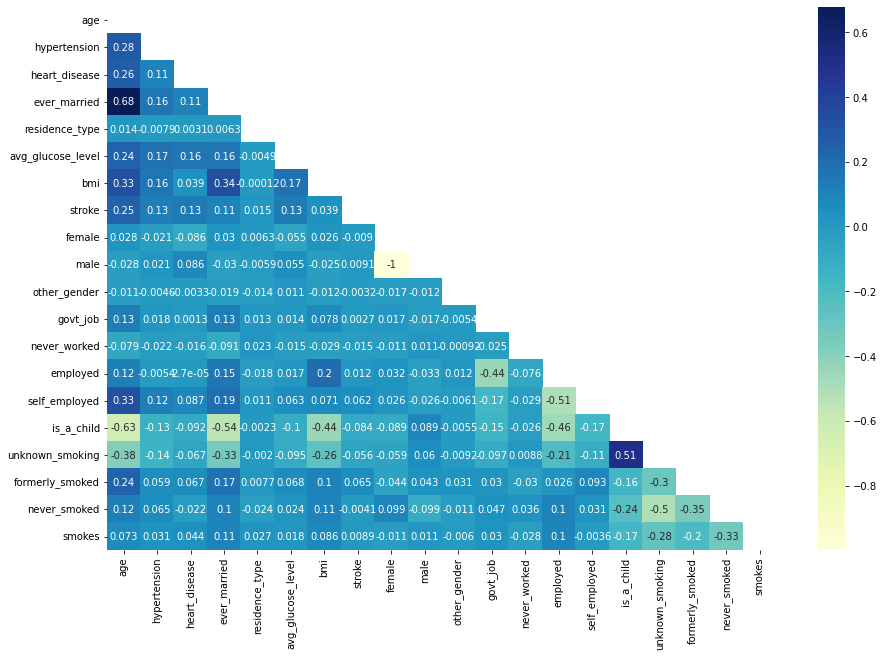

In [ ]:
# Review feature correlation, consider action for highly correlated features.
plt.subplots(figsize=(15,10))

mask = np.triu(np.ones_like(df.corr())) # triangle mask to hide duplicates

sns.heatmap(df.corr(),cmap="YlGnBu", annot=True, mask=mask)

None of the independant features have a high (0.75+) correlation that may skew models. All feature have a low (< 0.50) to moderate (0.50 >< 0.75) correlation. The 

The exception is that a high correlation with the label / predictive value (stroke) is optimal. None of the values have a high correlation with this feature. Counter intuitively, the 'is_a_child' has the highest correlation. 

Note: High correlation is acceptable for dependant features. There are no dependant variables in the above graph.

In [ ]:
df.skew()

age                  -0.137059
hypertension          2.715392
heart_disease         3.947244
ever_married         -0.657745
residence_type       -0.032107
avg_glucose_level     1.572284
bmi                   1.076716
stroke                4.193284
female               -0.348930
male                  0.349749
other_gender         71.484264
govt_job              2.219958
never_worked         15.146344
employed             -0.292800
self_employed         1.852619
is_a_child            2.143866
unknown_smoking       0.861974
formerly_smoked       1.727782
never_smoked          0.537548
smokes                1.913452
dtype: float64

Much of the data is far from a Gaussian (normal) distribution. This will negatively affect model performance and is likely due to the sampliung of data made avaiable on Kaggle. Consider [QuantileTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html#sklearn.preprocessing.QuantileTransformer) and [PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html#sklearn.preprocessing.PowerTransformer).

# Modeling

The modeling process is about creating a baseline to compare the tuning process against. 

## Regression

In [ ]:
# del to avoid dummie variable trap
dfr = df.copy()
del dfr['other_gender'] 
del dfr['is_a_child']
del dfr['unkown_smoking']

# Tuning

The tuning process consists of adjusting and measuring model parameters, and, if needed, revisiting feature engineering.

# Deployment